Решение задачи 2: Анализ эффективности терапии

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# 1. Правильная загрузка данных с учетом заголовка
try:
    df = pd.read_csv(
        '../data/weight.txt',
        sep='\t',  # Явно указываем табуляцию как разделитель
        header=0,  # Используем первую строку как заголовок
        dtype={'Before': float, 'After': float}
    )
    
    # Переименуем колонки для удобства
    df.columns = ['before', 'after']
    
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    raise

# 2. Очистка данных
print(f"Всего строк до очистки: {len(df)}")

# Удаление строк с пропущенными значениями
df = df.dropna()

# Проверка на отрицательные значения веса
if (df < 0).any().any():
    print("Внимание: обнаружены отрицательные значения веса!")
    df[df < 0] = np.nan
    df = df.dropna()

print(f"Строк после очистки: {len(df)}")
print("\nПервые 5 строк данных:")
display(df.head())

# 3. Сохранение очищенных данных
df.to_csv('../data/weight_cleaned.csv', index=False)

Всего строк до очистки: 29
Строк после очистки: 29

Первые 5 строк данных:


,before,after
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4
3,82.6,81.9
4,79.9,76.4


2. Предварительный анализ данных:


Описательная статистика:


,before,after
count,29.000000,29.000000
mean,82.689655,85.696552
std,4.845495,8.351924
min,70.000000,71.300000
25%,80.400000,81.900000
50%,82.600000,83.900000
75%,85.000000,90.900000
max,94.900000,103.600000


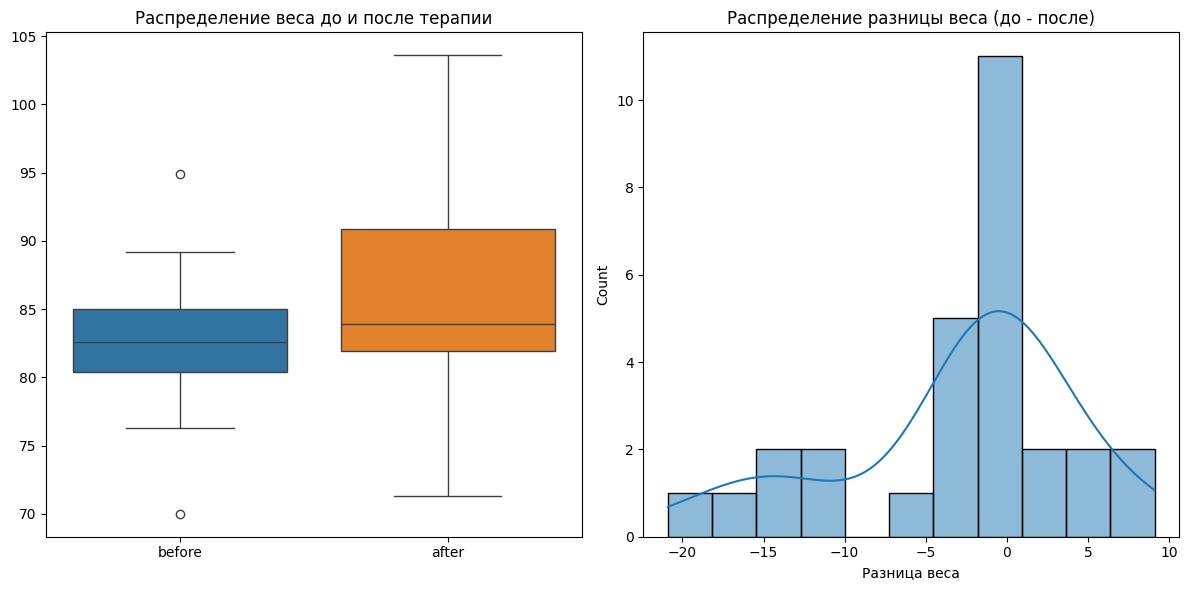

In [5]:
# Описательная статистика
print("\nОписательная статистика:")
display(df.describe())

# Визуализация
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['before', 'after']])
plt.title('Распределение веса до и после терапии')

plt.subplot(1, 2, 2)
sns.histplot(df['before'] - df['after'], kde=True)
plt.title('Распределение разницы веса (до - после)')
plt.xlabel('Разница веса')
plt.tight_layout()
plt.show()

3. Проверка условий для парного t-теста:

In [6]:
# Проверка нормальности разниц
diff = df['after'] - df['before']
_, p_value = stats.shapiro(diff)
print(f"Тест Шапиро-Уилка на нормальность разниц: p-value = {p_value:.4f}")

if p_value > 0.05:
    print("Разницы распределены нормально, используем парный t-тест")
    test_name = "Парный t-тест"
    stat, p = stats.ttest_rel(df['after'], df['before'])
else:
    print("Разницы не распределены нормально, используем критерий Уилкоксона")
    test_name = "Критерий Уилкоксона"
    stat, p = stats.wilcoxon(df['after'], df['before'])

Тест Шапиро-Уилка на нормальность разниц: p-value = 0.0079
Разницы не распределены нормально, используем критерий Уилкоксона


4. Проверка гипотезы:

In [7]:
alpha = 0.05
print(f"\nРезультаты теста ({test_name}):")
print(f"Статистика: {stat:.4f}")
print(f"p-value: {p:.6f}")

if p < alpha:
    print(f"\nВывод: p-value ({p:.6f}) < α ({alpha})")
    if diff.mean() > 0:
        print("Терапия статистически значимо эффективна (вес пациентов увеличился)")
    else:
        print("Терапия статистически значимо вредна (вес пациентов уменьшился)")
else:
    print(f"\nВывод: p-value ({p:.6f}) >= α ({alpha})")
    print("Терапия не показала статистически значимого эффекта")


Результаты теста (Критерий Уилкоксона):
Статистика: 131.5000
p-value: 0.065515

Вывод: p-value (0.065515) >= α (0.05)
Терапия не показала статистически значимого эффекта


5. Дополнительный анализ эффекта:


Размер эффекта (Cohen's d): 0.411
95% доверительный интервал: [0.23, 5.79]


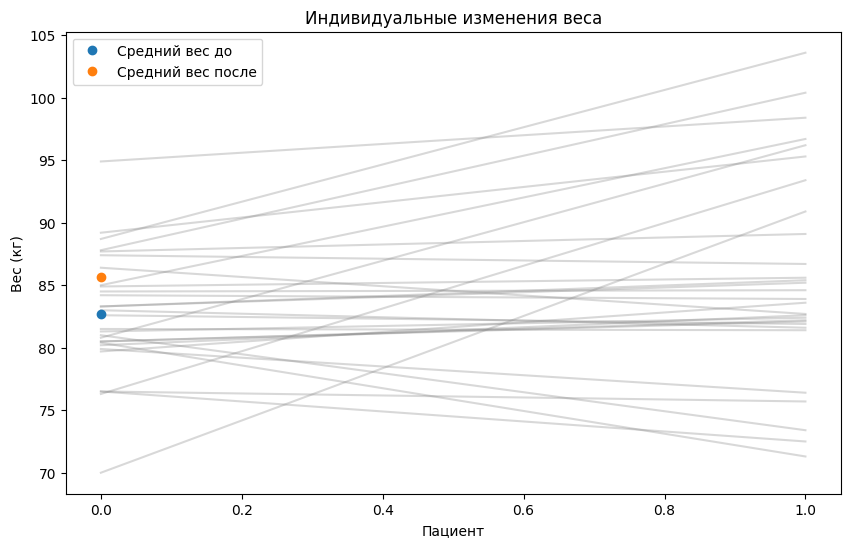

In [8]:
# Расчет размера эффекта
effect_size = diff.mean() / diff.std()
print(f"\nРазмер эффекта (Cohen's d): {effect_size:.3f}")

# Доверительный интервал
ci = stats.t.interval(0.95, len(diff)-1, loc=diff.mean(), scale=stats.sem(diff))
print(f"95% доверительный интервал: [{ci[0]:.2f}, {ci[1]:.2f}]")

# Визуализация индивидуальных изменений
plt.figure(figsize=(10, 6))
plt.plot([df['before'], df['after']], color='gray', alpha=0.3)
plt.plot(df['before'].mean(), 'o', label='Средний вес до')
plt.plot(df['after'].mean(), 'o', label='Средний вес после')
plt.title('Индивидуальные изменения веса')
plt.xlabel('Пациент')
plt.ylabel('Вес (кг)')
plt.legend()
plt.show()

6. Сохранение результатов:

In [10]:
results = {
    'test_used': test_name,
    'test_statistic': float(stat),
    'p_value': float(p),
    'effect_size': float(effect_size),
    'mean_diff': float(diff.mean()),
    'ci_lower': float(ci[0]),
    'ci_upper': float(ci[1]),
    'conclusion': 'effective' if p < alpha and diff.mean() > 0 else 'not effective'
}

import json
with open('../results/task2_results.json', 'w') as f:
    json.dump(results, f, indent=2)